In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from micrograd import Value, Neuron, Layer, MLP

In [3]:
np.random.seed(1337) # this guarantees the same seed of random numbers for every run of the program
random.seed(1337)

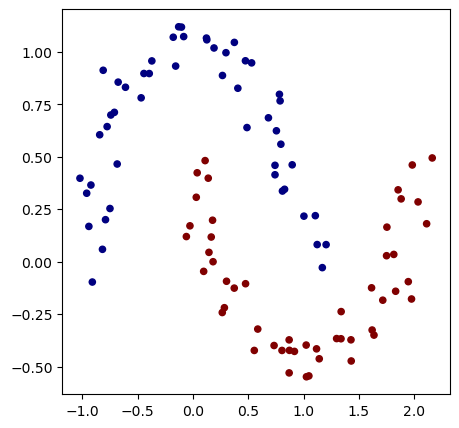

In [4]:
# make up a dataset
from sklearn.datasets import make_moons, make_blobs

X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2d
plt.figure(figsize=(5, 5))
# print(X[2])
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [5]:
# initialize a model
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print('number of params', len(model.parameters()))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of params 337


In [6]:
inputs = [list(map(Value, xrow)) for xrow in X]
print(inputs[0])
print(model(inputs[0]))
print(y[0])


[Value(data=1.1221146075409685, grad=0.0), Value(data=0.08147717341718697, grad=0.0)]
Value(data=-0.24267959107182535, grad=0.0)
-1


In [7]:
# loss function
def loss(batch_size=None):

    # inline DataLoader
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]

    # forward the model to get scores
    scores = list(map(model, inputs))
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum(p*p for p in model.parameters())
    total_loss = data_loss + reg_loss

    # get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)


Value(data=0.8958441028683222, grad=0.0) 0.5


In [8]:
# optimization

loss_list = []

for k in range(100):

    # forward
    total_loss, acc = loss()

    # backward
    model.zero_grad()
    total_loss.backward()

    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100 # decays linearly to converge better
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")
    
    loss_list.append(total_loss.data)

step 0 loss 0.8958441028683222, accuracy 50.0%
step 1 loss 1.7235905336972022, accuracy 81.0%
step 2 loss 0.7429006313851131, accuracy 77.0%
step 3 loss 0.7705641260584198, accuracy 82.0%
step 4 loss 0.3692793385976537, accuracy 84.0%
step 5 loss 0.313545481918522, accuracy 86.0%
step 6 loss 0.2814234349772435, accuracy 89.0%
step 7 loss 0.26888733313983904, accuracy 91.0%
step 8 loss 0.2567147286057417, accuracy 91.0%
step 9 loss 0.27048625516379227, accuracy 91.0%
step 10 loss 0.24507023853658041, accuracy 91.0%
step 11 loss 0.25099055297915035, accuracy 92.0%
step 12 loss 0.2156095185192295, accuracy 91.0%
step 13 loss 0.23090378446402737, accuracy 93.0%
step 14 loss 0.20152151227899448, accuracy 92.0%
step 15 loss 0.22574506279282228, accuracy 93.0%
step 16 loss 0.19447987596204105, accuracy 92.0%
step 17 loss 0.21089496199246363, accuracy 93.0%
step 18 loss 0.15983077356303604, accuracy 94.0%
step 19 loss 0.1845374874688392, accuracy 93.0%
step 20 loss 0.18977522856087645, accurac

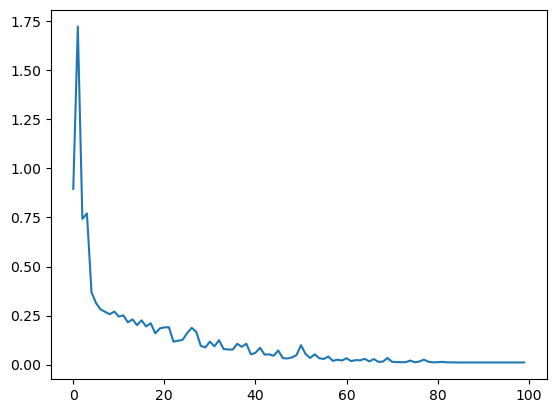

In [9]:
plt.plot(loss_list)

(-1.048639298268643, 1.451360701731357)

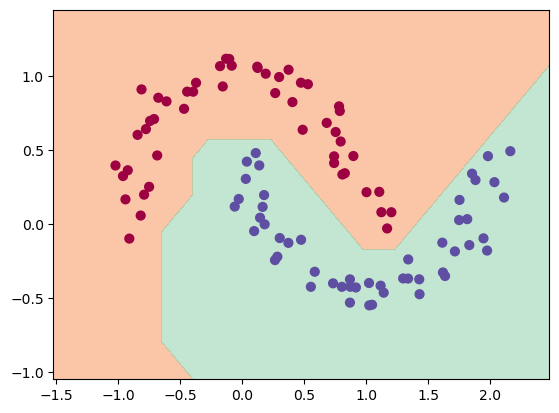

In [27]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]

# Xmesh is a collection of all grid points, formatted as [X, Y], form 2d array
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))

Z = np.array([s.data > 0 for s in scores])
# print(Z.shape)
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
# plt.scatter(xx, yy, c=Z, s=10, cmap='jet')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

In [20]:
a = np.array(([1, 2], [1, 2], [1, 2]))
print(a)
a.shape

[[1 2]
 [1 2]
 [1 2]]


(3, 2)

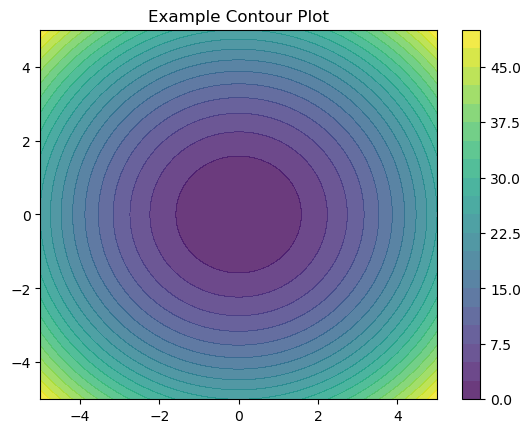

In [21]:
# Simple example
# Generate a grid
x1 = np.linspace(-5, 5, 100)
y1 = np.linspace(-5, 5, 100)
xx, yy = np.meshgrid(x1, y1)

# Compute Z values (e.g., decision function)
Z = xx**2 + yy**2  # A circular decision boundary

# Create filled contour plot
plt.contourf(xx, yy, Z, levels=20, cmap="viridis", alpha=0.8)
plt.colorbar()  # Optional: shows color scale
plt.title("Example Contour Plot")
plt.show()


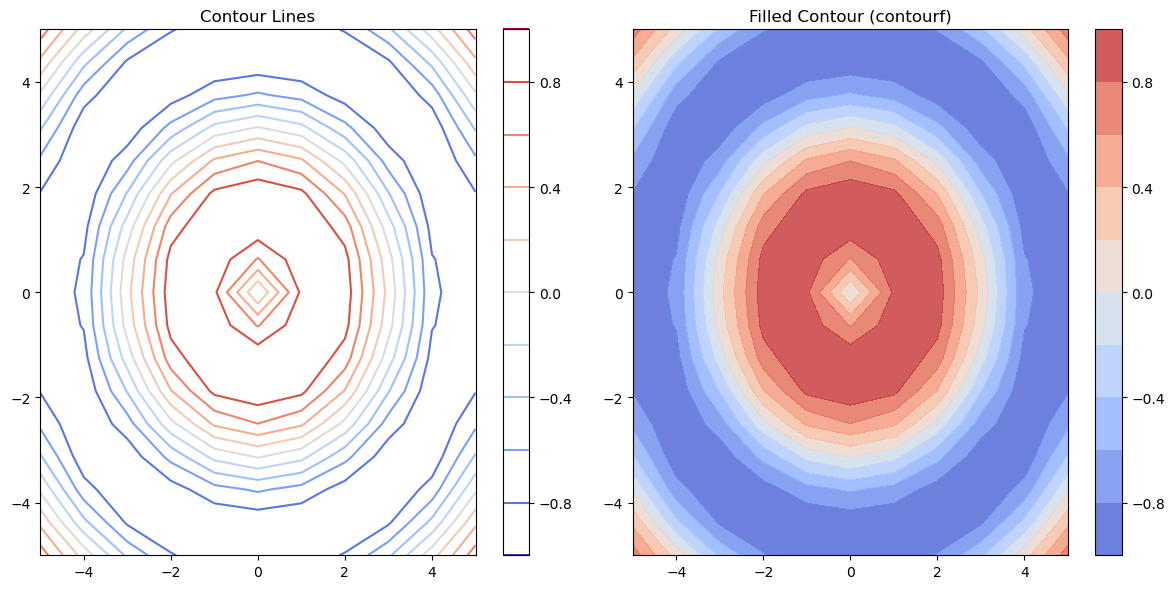

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Create a grid
x1 = np.linspace(-5, 5, 11)  # 11 points from -5 to 5
y1 = np.linspace(-5, 5, 17)  # 17 points from -5 to 5
xx, yy = np.meshgrid(x1, y1)  # Create 2D grid arrays

# Step 2: Compute Z values
Z = np.sin(np.sqrt(xx**2 + yy**2))  # Z depends on (x, y)

# Step 3: Plot with contour and contourf
plt.figure(figsize=(12, 6))

# Contour plot
plt.subplot(1, 2, 1)
plt.contour(xx, yy, Z, levels=10, cmap="coolwarm")
plt.title("Contour Lines")
plt.colorbar()

# Filled Contour plot
plt.subplot(1, 2, 2)
plt.contourf(xx, yy, Z, levels=10, cmap="coolwarm", alpha=0.8)
plt.title("Filled Contour (contourf)")
plt.colorbar()

plt.tight_layout()
plt.show()
